In [40]:
import torch
import numpy as np
import os
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)

Using cache found in /home/m256149/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [29]:
out = model(torch.rand(14,1,224,224).cuda(device = device))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [6]:
out.shape

torch.Size([1, 1, 512, 512])

In [7]:
torch.round(out)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 1., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<RoundBackward0>)

In [8]:
import matplotlib.pyplot as plt

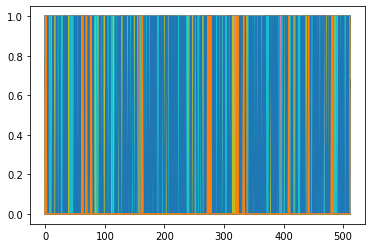

In [9]:
plt.plot(torch.round(out)[0,0].detach().numpy())

In [43]:
import numpy as np
import torch
import torchio as tio
import os
import matplotlib.pyplot as plt
import json
import torch.nn as nn
from torchinfo import summary
import adabound
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from torch.optim import Adam,SGD

## Collect data

In [44]:
def get_trainbatch(traindir,labdir,batch_size):
    np.random.seed(0)
    #np.random.shuffle(traindir)
    return [(traindir[i:i + batch_size],labdir[i:i + batch_size]) for i in range(0, len(traindir), batch_size)]
device = 'cuda:0'
datadir = '/home/m256149/Documents/LeftVentricleSegmentation/Resources-4/'
#fat,water,study
np.random.seed(0)
for a,b,c in os.walk(datadir):
    break
tr = []
lb = []
for i in b:
    for q,fi,qw in os.walk(datadir+i+'/'):
        break
    for l in qw:
        if 'frame' in l:
            if 'gt' not in l:
                tr.append(datadir+i+'/'+l)
                lb.append(datadir+i+'/'+l[:-7]+'_gt'+'.nii.gz')

In [54]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        """
               I am assuming the model does not have sigmoid layer in the end. if that is the case, change torch.sigmoid(logits) to simply logits
        """
        probs = logits#torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [58]:
train = tr
num_epochs = 1000
batch_size = 8
#warnings.filterwarnings("ignore")
#optimizer = adabound.AdaBound(vgg3d.parameters(), lr=0.4,weight_decay = 0.004,eps = 1e-4, final_lr=0.01)
#optimizer = SGD(model.parameters(), lr=.01,momentum=0.9)#,momentum=0.9,weight_decay=0.0005)#SGD(vgg3d.parameters(), lr=0.01,momentum=0.9,weight_decay=0.0005)
optimizer = Adam(model.parameters(), lr=.001)
criterion = SoftDiceLoss()#diceloss()#nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() ### momentum=0.9 diceloss()#

if torch.cuda.is_available():
    model = model.cuda(device = device)
    criterion = criterion.cuda(device = device)
val_losses = []
train_losses_ep = []
trans = tio.CropOrPad((1,256,256))

tRESCALE = tio.RescaleIntensity((-1,1))
for epoch in range(num_epochs):
    train_losses = []
    for batch,lab in get_trainbatch(train,lb,int(batch_size)):
        y_train = []
        for cnt,i in enumerate(batch):
            if cnt == 0:     
                orig = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
                y_train = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) ==2
                
                orig = tRESCALE(trans(orig))
                y_train = trans(y_train)
            else:
                temp = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
                temp_lab = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) == 2
                
                temp = tRESCALE(trans(temp))
                temp_lab = trans(temp_lab)
                
                #print(temp_lab.shape,temp.shape,orig.shape,y_train.shape)
                y_train = torch.cat((y_train,temp_lab),dim = 0)
                orig = torch.cat((orig,temp),dim = 0)
        
        
        orig = orig.float().cuda(device = device)
        y_train = y_train.float().cuda(device = device)
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        output_train = model(orig)
        loss_train = criterion(output_train, y_train) 
        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())
        del orig
        del y_train
    train_losses_ep.append(np.mean(train_losses))
    if epoch%(num_epochs/25) == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'val loss :', '\t', 'train loss : ', np.mean(train_losses))

Epoch :  1 	 val loss : 	 train loss :  0.9480567574501038
Epoch :  41 	 val loss : 	 train loss :  0.8833778858184814
Epoch :  81 	 val loss : 	 train loss :  0.6896663975715637
Epoch :  121 	 val loss : 	 train loss :  0.4483934497833252
Epoch :  161 	 val loss : 	 train loss :  0.289490852355957
Epoch :  201 	 val loss : 	 train loss :  0.21756795883178712
Epoch :  241 	 val loss : 	 train loss :  0.1663114285469055
Epoch :  281 	 val loss : 	 train loss :  0.13984184026718138
Epoch :  321 	 val loss : 	 train loss :  0.11940318822860718
Epoch :  361 	 val loss : 	 train loss :  0.11246581554412842
Epoch :  401 	 val loss : 	 train loss :  0.09171859264373779
Epoch :  441 	 val loss : 	 train loss :  0.08285418510437012
Epoch :  481 	 val loss : 	 train loss :  0.07244786262512207
Epoch :  521 	 val loss : 	 train loss :  0.05266017913818359
Epoch :  561 	 val loss : 	 train loss :  0.023679311275482177
Epoch :  601 	 val loss : 	 train loss :  0.019786388874053956
Epoch :  641 	 va

In [51]:
orig.shape,y_train.shape

(torch.Size([86, 1, 256, 256]), torch.Size([86, 1, 256, 256]))

In [59]:
for i in range(100):
    plt.figure(i)
    
    plt.imshow(model(orig).cpu().detach().numpy()[i,0,:,:])
    plt.figure(i+100)
    plt.imshow(y_train.cpu()[i,0,:,:])

NameError: name 'orig' is not defined

<Figure size 432x288 with 0 Axes>

In [33]:
sum(sum(model(orig) ==1)).sum() , sum(sum(model(orig) ==0)).sum()

(tensor(6553600, device='cuda:0'), tensor(0, device='cuda:0'))

In [48]:
model(orig[0,:,:,:][None])

NameError: name 'orig' is not defined

In [60]:
for batch,lab in get_trainbatch(train,lb,int(batch_size)):
    y_train = []
    for cnt,i in enumerate(batch):
        if cnt == 0:     
            orig = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            y_train = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) ==2

            orig = tRESCALE(trans(orig))
            y_train = trans(y_train)
        else:
            temp = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            temp_lab = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) == 2

            temp = tRESCALE(trans(temp))
            temp_lab = trans(temp_lab)

            #print(temp_lab.shape,temp.shape,orig.shape,y_train.shape)
            y_train = torch.cat((y_train,temp_lab),dim = 0)
            orig = torch.cat((orig,temp),dim = 0)

In [62]:
orig = orig.float().cuda(device = device)
y_train = y_train.float().cuda(device = device)


<ipython-input-67-cd79d5b356ea>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i+200)


IndexError: index 62 is out of bounds for axis 0 with size 62

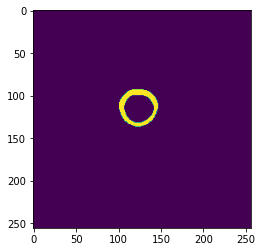

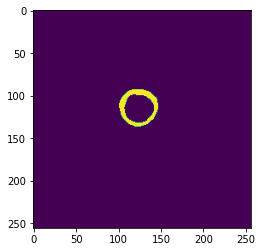

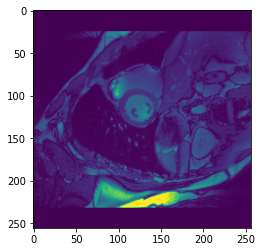

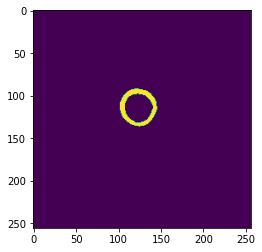

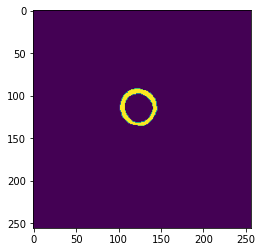

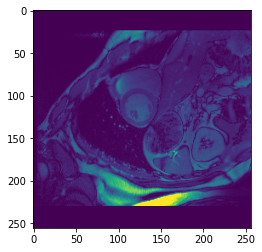

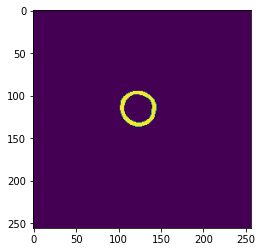

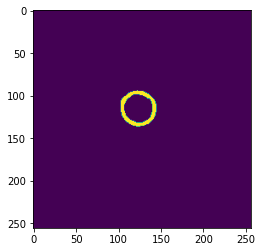

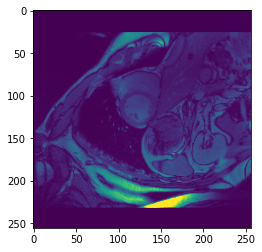

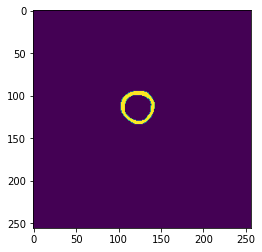

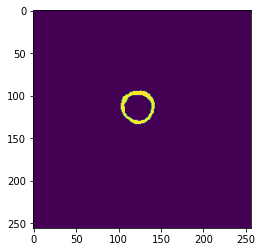

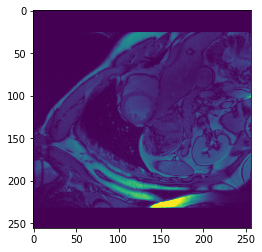

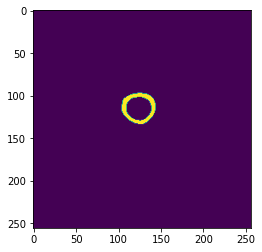

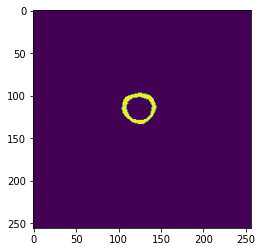

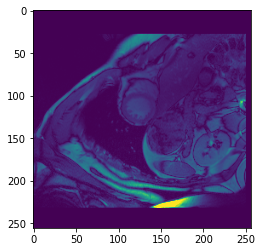

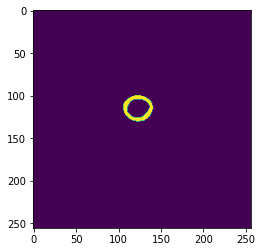

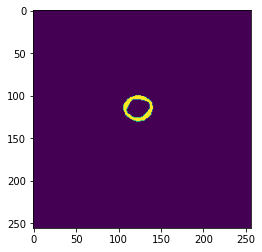

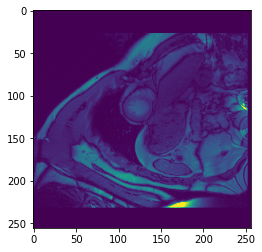

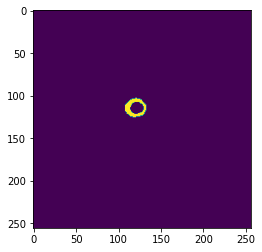

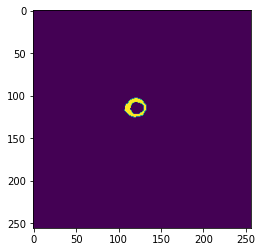

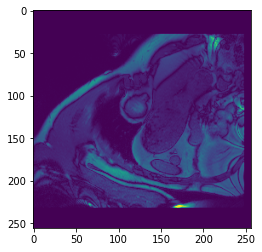

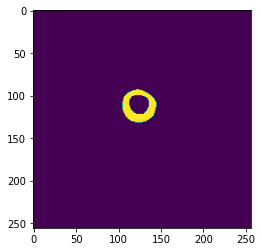

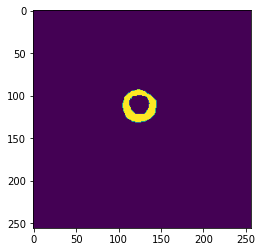

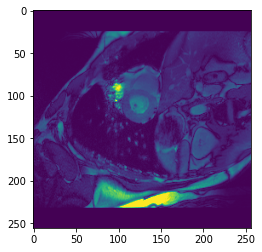

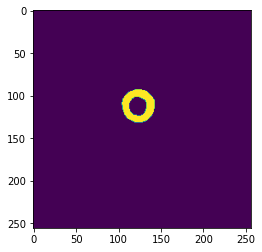

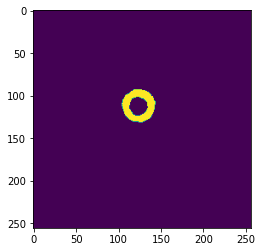

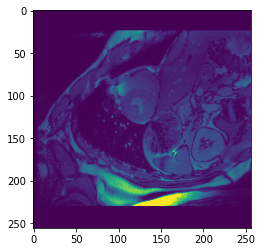

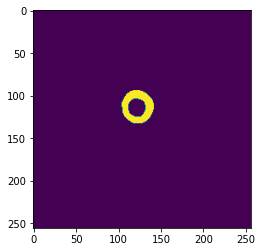

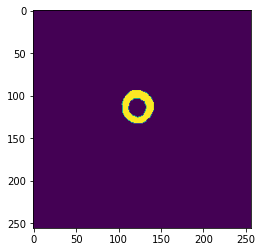

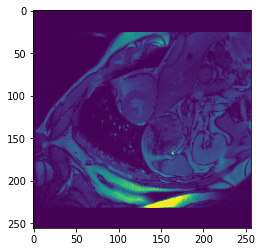

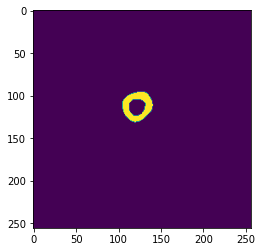

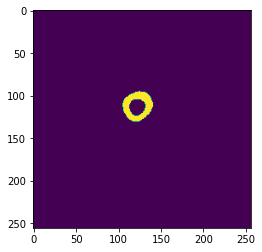

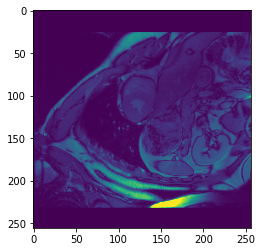

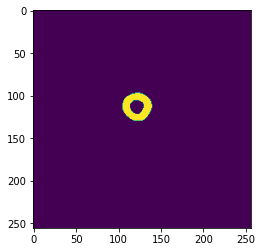

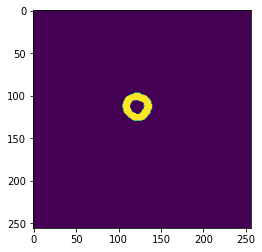

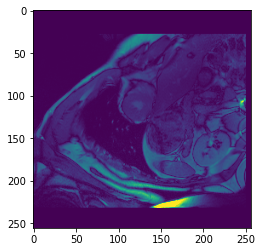

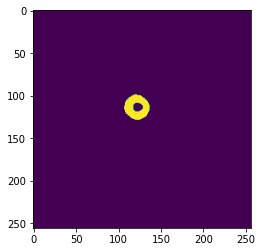

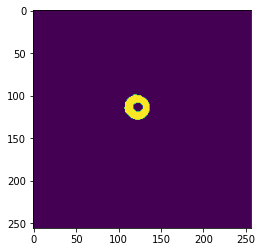

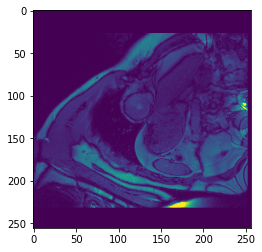

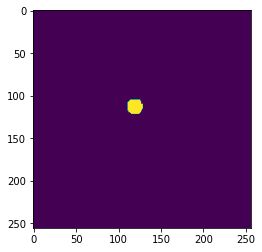

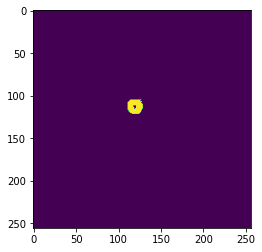

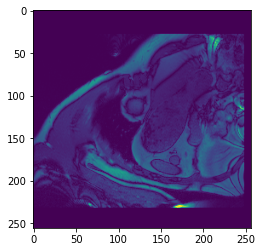

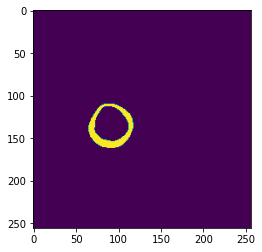

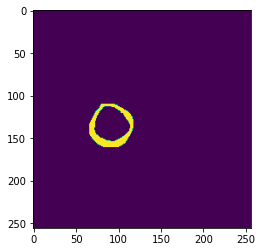

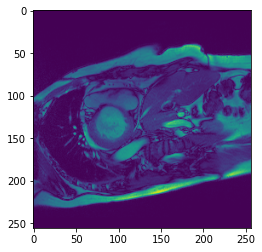

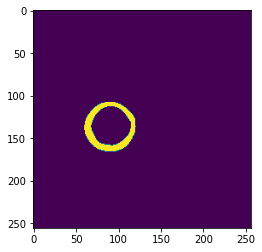

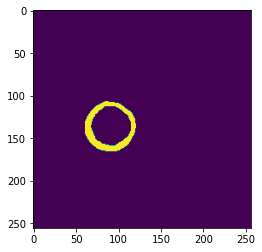

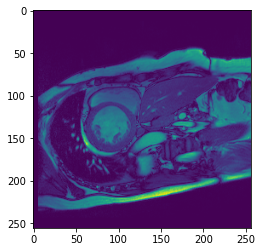

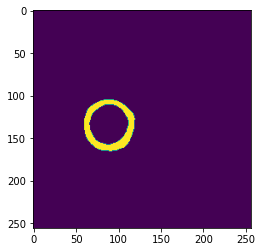

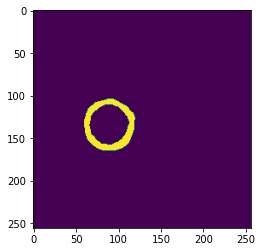

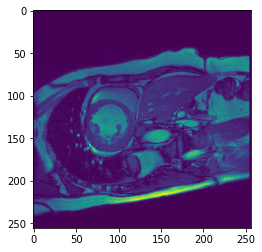

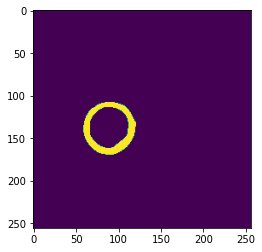

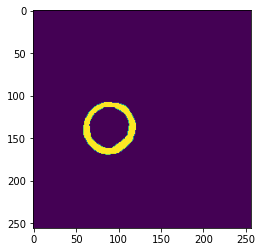

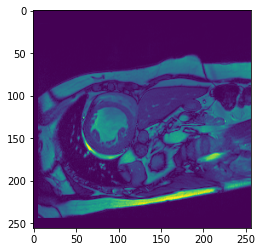

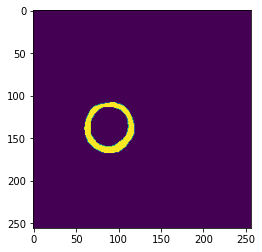

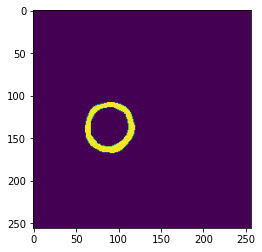

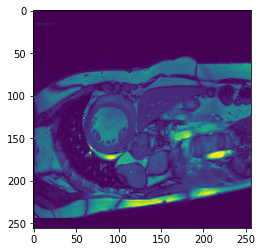

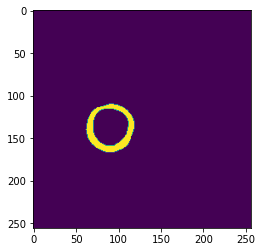

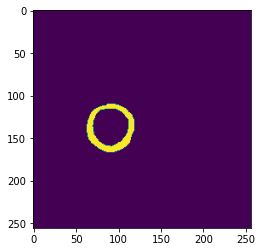

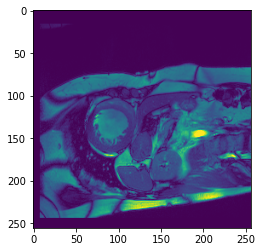

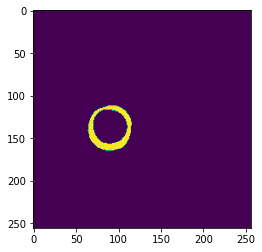

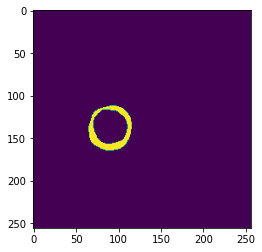

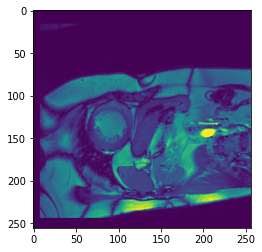

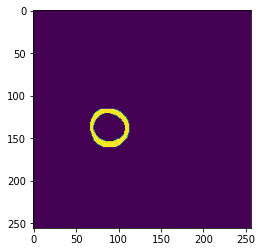

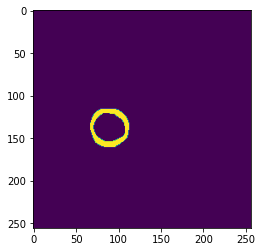

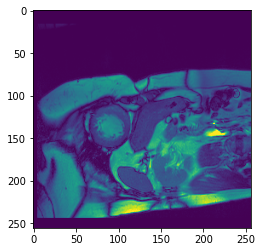

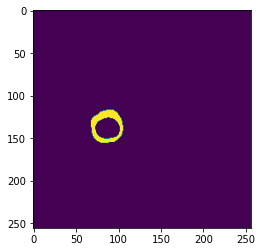

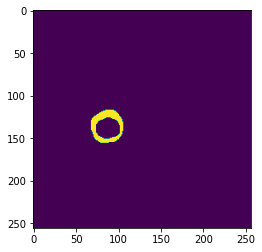

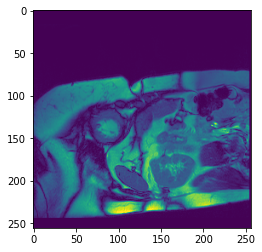

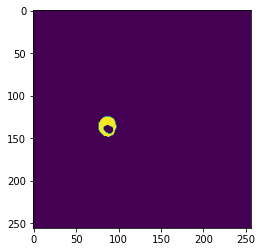

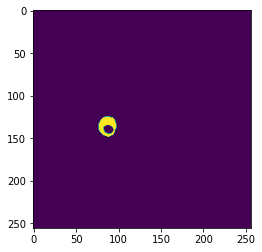

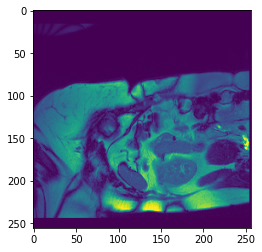

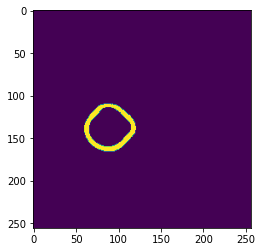

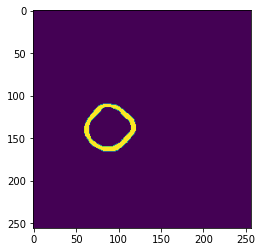

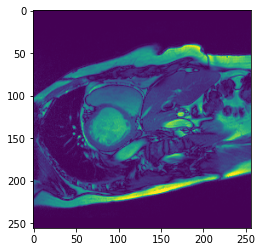

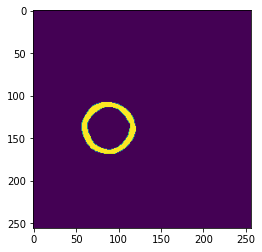

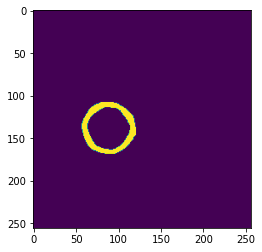

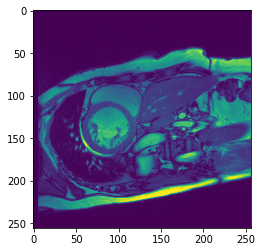

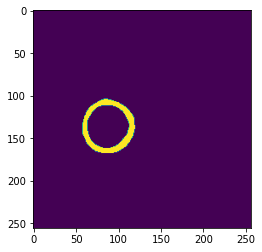

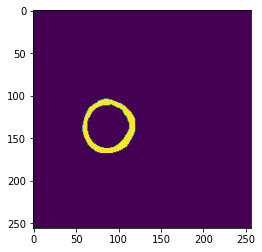

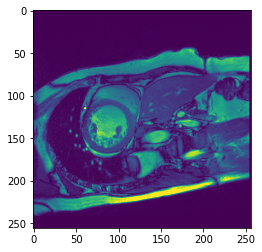

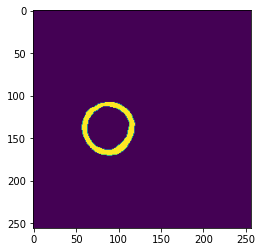

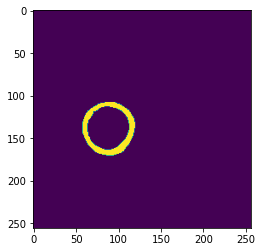

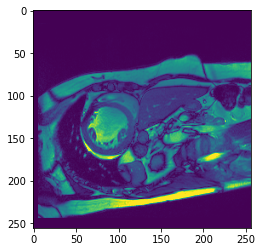

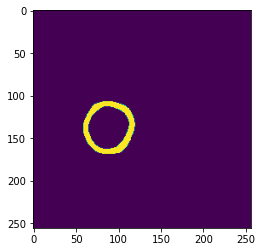

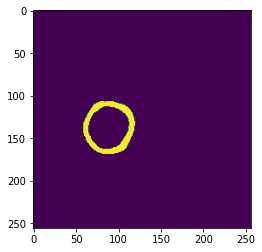

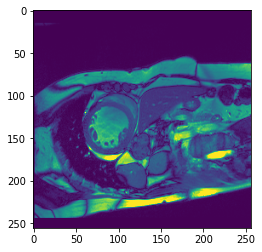

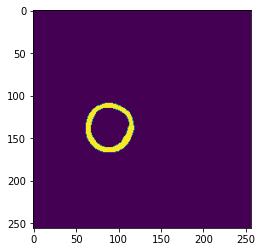

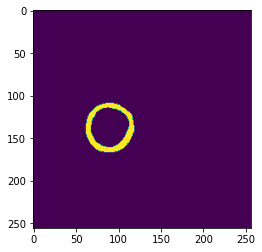

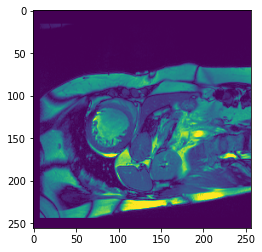

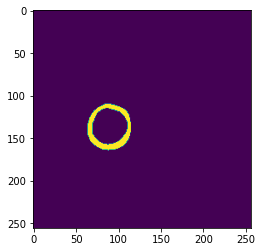

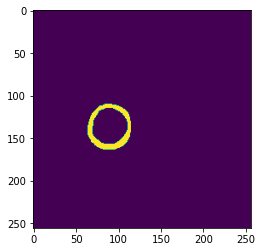

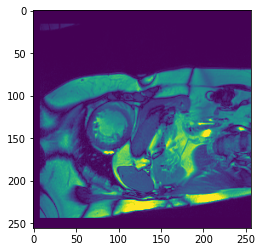

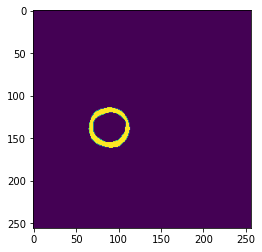

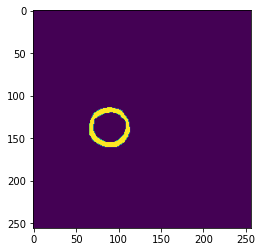

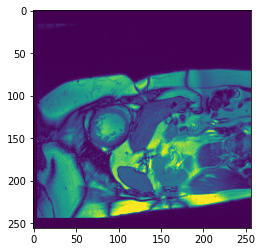

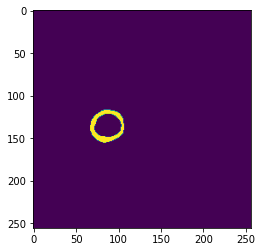

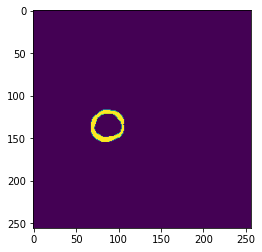

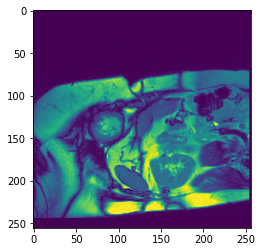

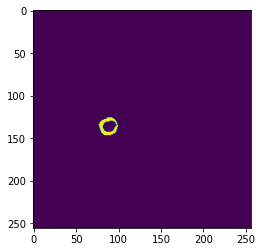

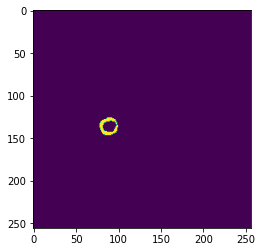

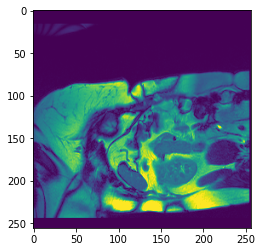

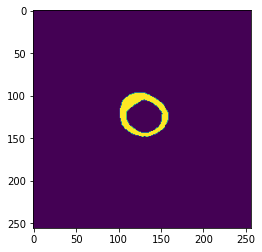

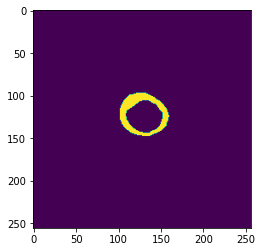

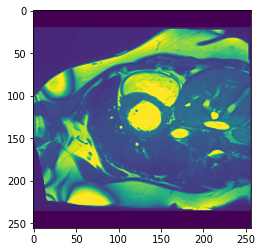

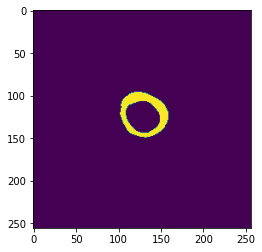

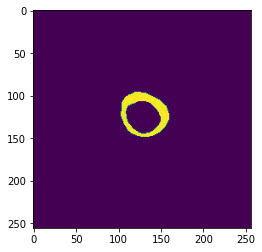

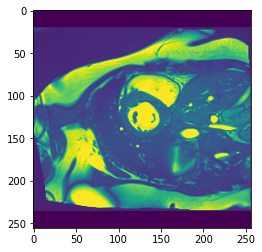

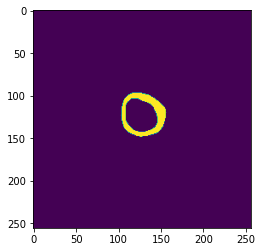

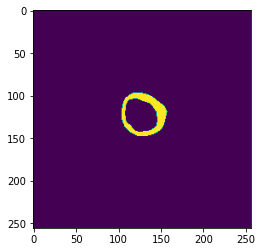

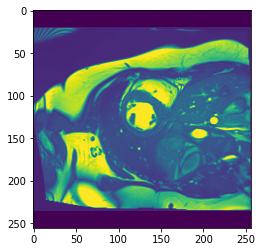

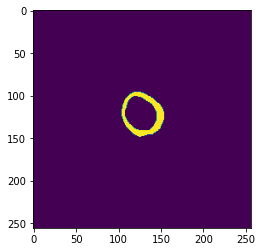

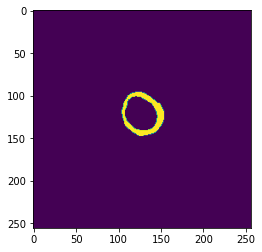

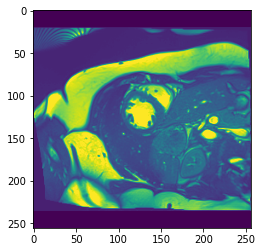

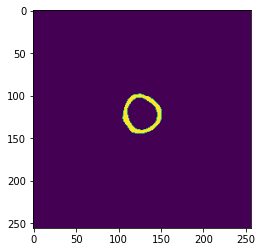

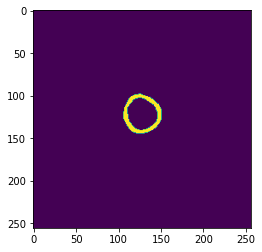

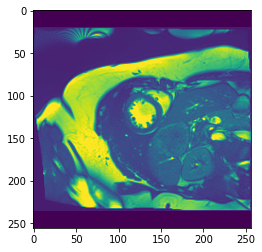

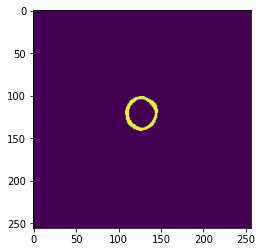

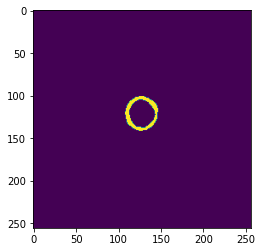

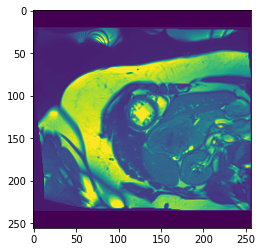

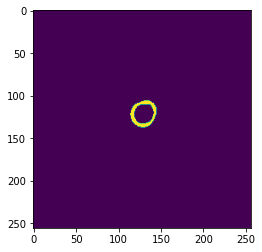

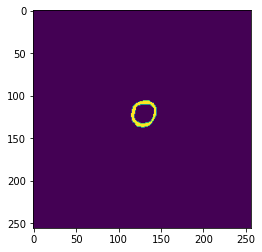

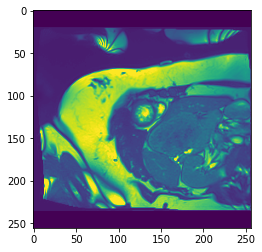

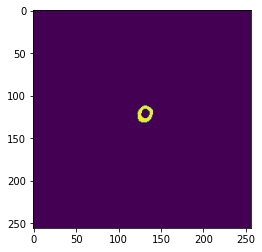

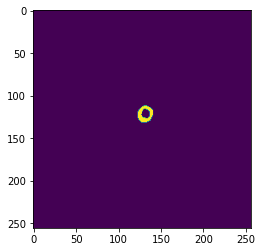

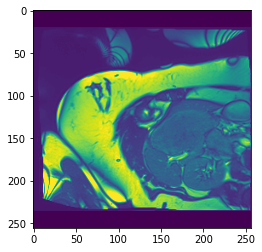

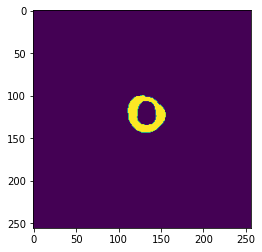

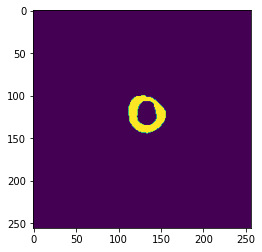

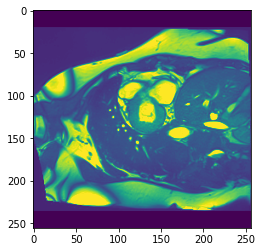

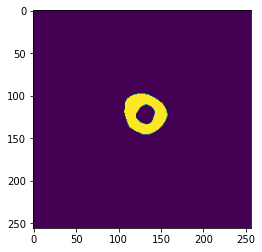

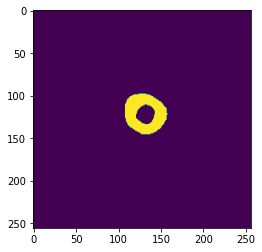

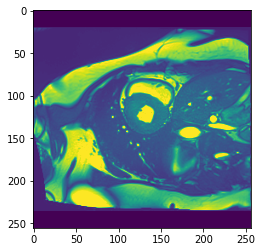

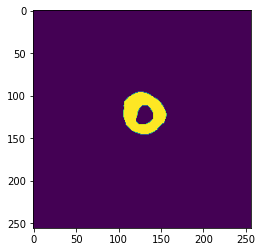

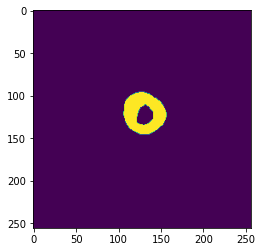

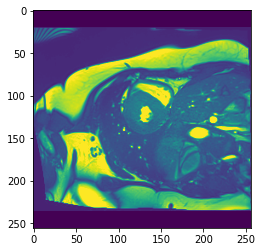

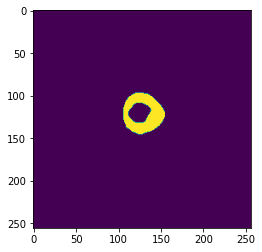

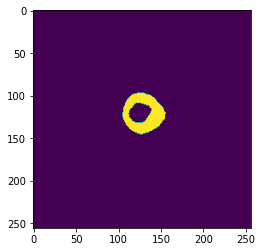

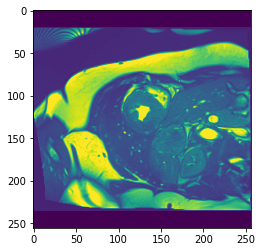

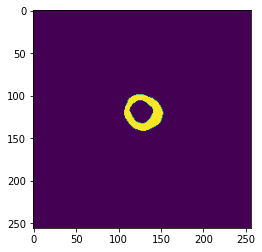

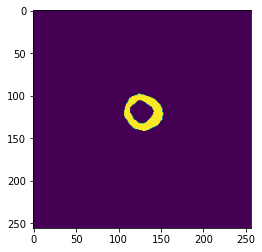

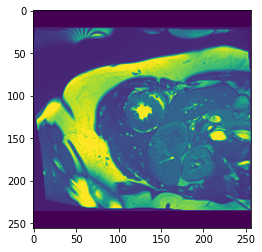

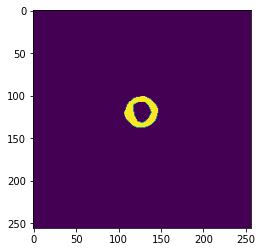

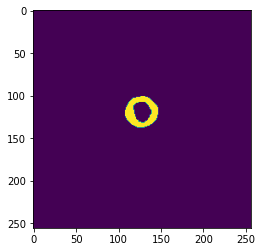

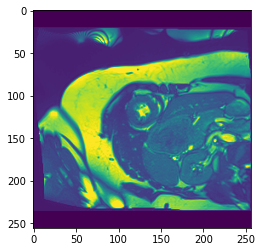

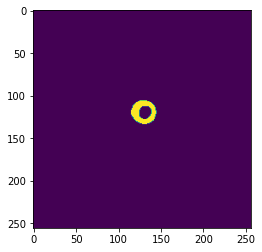

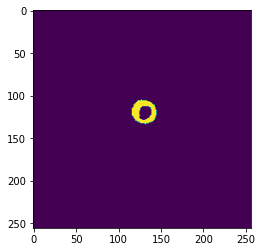

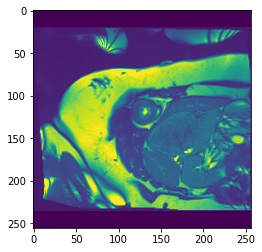

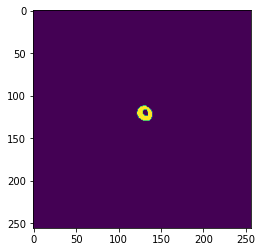

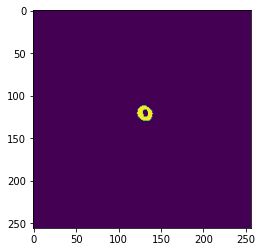

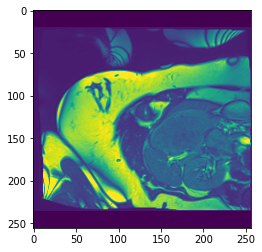

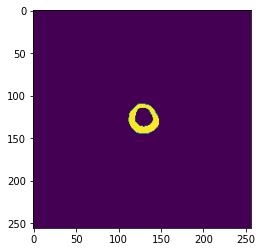

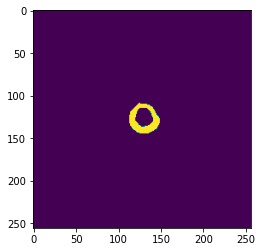

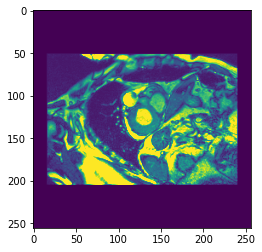

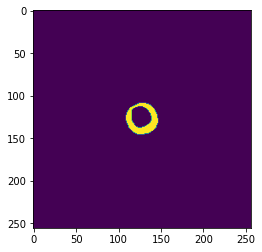

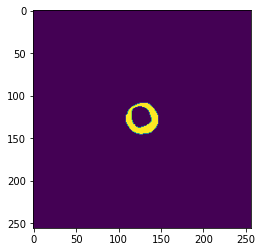

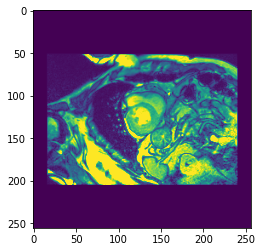

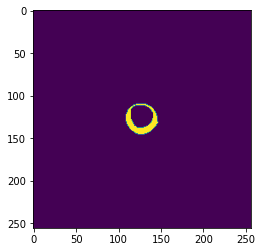

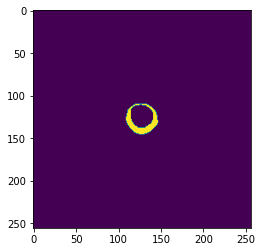

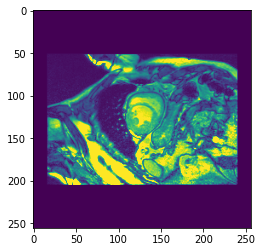

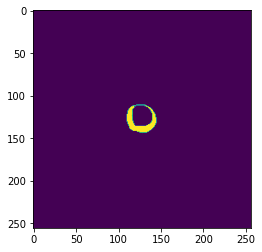

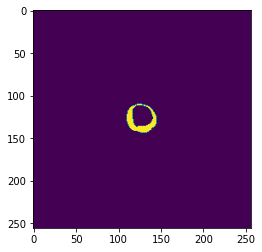

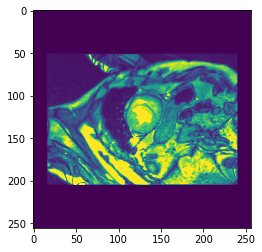

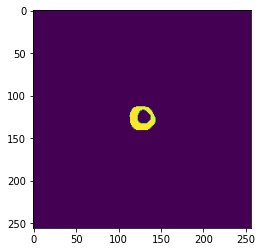

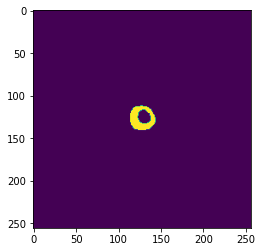

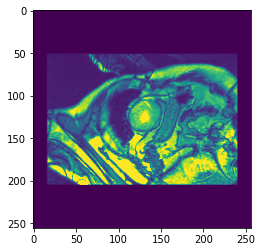

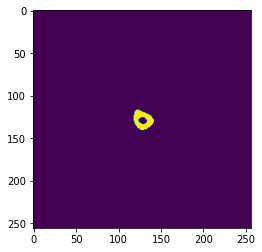

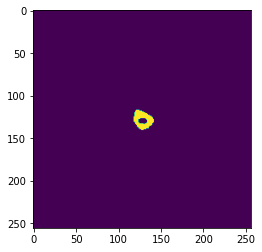

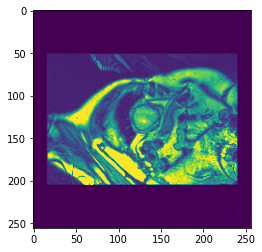

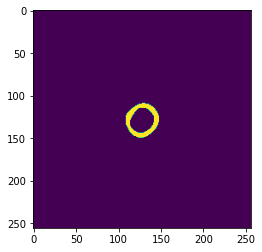

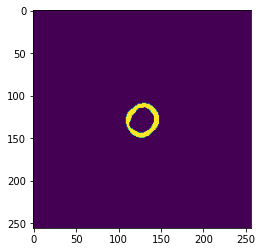

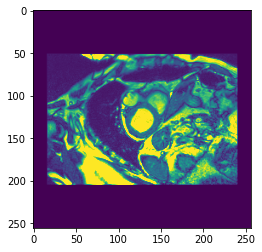

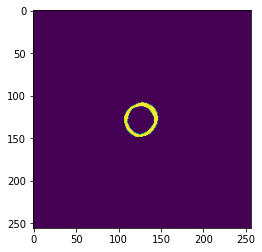

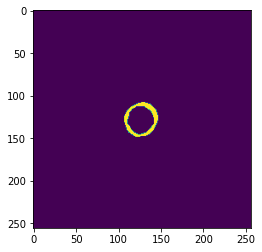

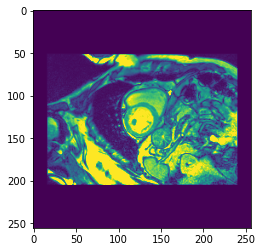

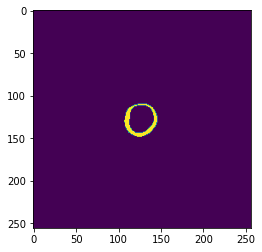

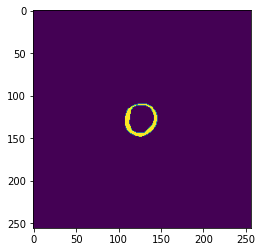

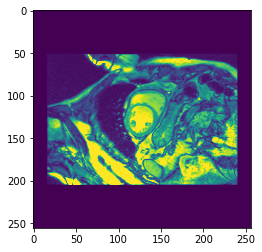

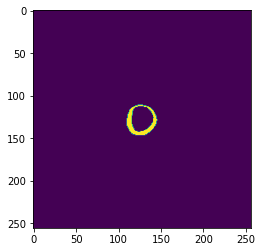

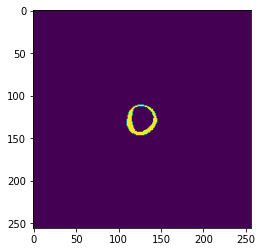

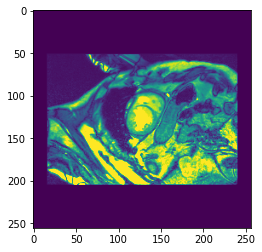

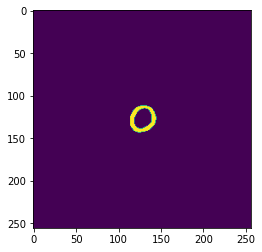

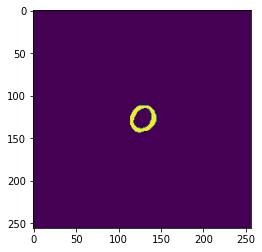

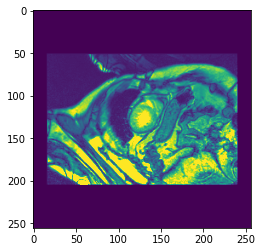

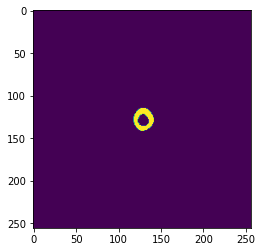

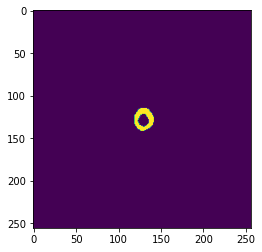

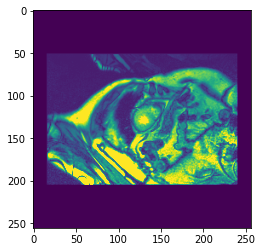

<Figure size 432x288 with 0 Axes>

In [67]:
for i in range(100):
    plt.figure(i)
    
    plt.imshow(model(orig).cpu().detach().numpy()[i,0,:,:])
    plt.figure(i+100)
    plt.imshow(y_train.cpu()[i,0,:,:])
    
    plt.figure(i+200)
    plt.imshow(orig.cpu().detach().numpy()[i,0,:,:],vmin = -1,vmax = 0)

## Read test data

In [68]:
datadir = '/home/m256149/Documents/LeftVentricleSegmentation/Resources-5/'
#fat,water,study
for a,b,c in os.walk(datadir):
    break
tr = []
lb = []
for i in b:
    for q,fi,qw in os.walk(datadir+i+'/'):
        break
    for l in qw:
        if 'frame' in l:
            if 'gt' not in l:
                tr.append(datadir+i+'/'+l)
                lb.append(datadir+i+'/'+l[:-7]+'_gt'+'.nii.gz')

## calculate dice score on test set

In [87]:
model.eval()
ds = 0
num_slice = 0 
batch_size = 1
for batch,lab in get_trainbatch(tr,lb,int(batch_size)):
    y_test = []
    for cnt,i in enumerate(batch):
        if cnt == 0:     
            orig = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            y_test = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) ==2

            orig = tRESCALE(trans(orig))
            y_test = trans(y_test)
        else:
            temp = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            temp_lab = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) == 2

            temp = tRESCALE(trans(temp))
            temp_lab = trans(temp_lab)

            #print(temp_lab.shape,temp.shape,orig.shape,y_train.shape)
            y_test = torch.cat((y_test,temp_lab),dim = 0)
            orig = torch.cat((orig,temp),dim = 0)


    orig = orig.float().cuda(device = device)
    y_test = y_test.float().cuda(device = device)
    ds += criterion(torch.round(model(orig)),y_test)*y_test.shape[0]
    num_slice += y_test.shape[0]
    del orig
    del y_test
print('average dice score', ds/num_slice)

RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 47.52 GiB total capacity; 45.58 GiB already allocated; 21.06 MiB free; 45.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [86]:
torch.save(model.state_dict(),'/home/m256149/Documents/LeftVentricleSegmentation/unet.pt')

In [91]:
trainedmodel = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)
trainedmodel.load_state_dict(torch.load('/home/m256149/Documents/LeftVentricleSegmentation/unet.pt'))

Using cache found in /home/m256149/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [96]:
trainedmodel.eval()
ds = 0
num_slice = 0 
batch_size = 8
for batch,lab in get_trainbatch(tr,lb,int(batch_size)):
    y_test = []
    for cnt,i in enumerate(batch):
        if cnt == 0:     
            orig = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            y_test = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) ==2

            orig = tRESCALE(trans(orig))
            y_test = trans(y_test)
        else:
            temp = tio.ScalarImage(batch[cnt]).data.permute(3,0,1,2)
            temp_lab = tio.ScalarImage(lab[cnt]).data.permute(3,0,1,2) == 2

            temp = tRESCALE(trans(temp))
            temp_lab = trans(temp_lab)

            #print(temp_lab.shape,temp.shape,orig.shape,y_train.shape)
            y_test = torch.cat((y_test,temp_lab),dim = 0)
            orig = torch.cat((orig,temp),dim = 0)


    orig = orig.float()#.cuda(device = device)
    y_test = y_test.float()#.cuda(device = device)
    ds += criterion(torch.round(trainedmodel(orig)),y_test).item()*y_test.shape[0]
    num_slice += y_test.shape[0]
    print(y_test.shape[0])
    del orig
    del y_test
print('average dice score', ds/num_slice)

70
76
92
90
74
88
120
86
82
94
80
88
36
average dice score 0.13156511537647603


## save masks as nifti

In [114]:
trainedmodel.eval()
i = 0
for batch,lab in zip(tr,lb):
    orig = tio.ScalarImage(batch).data.permute(3,0,1,2)
    orig = tRESCALE(trans(orig))

    orig = orig.float()#.cuda(device = device)

    maskdata = torch.round(trainedmodel(orig)).permute(1,2,3,0).detach()
    
   
    y_test = tio.ScalarImage(lab).data.permute(3,0,1,2) ==2
    y_test = trans(y_test)
    
    
    # save orig, maskdata, y_test
    temp = tio.ScalarImage(batch)
    temp.data = orig.permute(1,2,3,0).detach()
    temp.save(batch[:-14] + batch[-9:-7] +'resize.nii.gz')
    
    
    
    temp = tio.ScalarImage(lab)
    temp.data = maskdata
    temp.save(lab[:-10] + '_outgt.nii.gz')
    
    temp = tio.ScalarImage(lab)
    temp.data = y_test.permute(1,2,3,0).detach()
    temp.save(lab[:-10] + '_resizegt.nii.gz')


    
    del orig
    del y_test
    i += 1

<ipython-input-114-9de7fc720148>:18: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  temp.data = orig.permute(1,2,3,0).detach()
<ipython-input-114-9de7fc720148>:24: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  temp.data = maskdata
<ipython-input-114-9de7fc720148>:28: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  temp.data = y_test.permute(1,2,3,0).detach()
